In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer()
        uidArray = self.grouped_by_productid.UserId.as_matrix()
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [3]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

In [4]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
# amazonData = ProcessAmazon('Amazon.csv', 4)
amazonData = ProcessAmazon('Amazon.csv', 5)

Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1                   

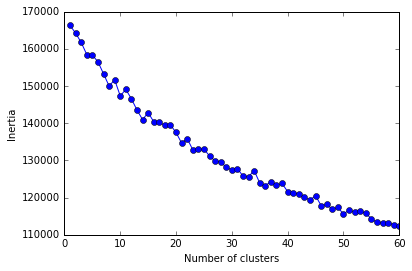

Distortion: 112251.57


In [5]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
# for i in range(1, 11):
# for i in range(1, 6):
for i in range(1, 61): ##crashes system
# for i in range(1, 41): ##crashes system
# for i in range(1, 21):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
# plt.plot(range(1, 11), distortions, marker='o')
# plt.plot(range(1, 6), distortions, marker='o')
plt.plot(range(1, 61), distortions, marker='o') ##crashes system
# plt.plot(range(1, 41), distortions, marker='o') ##crashes system
# plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

print('Distortion: %.2f' % km.inertia_)

In [6]:
# fit KMeans with 10 clusters
from sklearn.cluster import KMeans
# km = KMeans(n_clusters=10)
# km = KMeans(n_clusters=5)
km = KMeans(n_clusters=60)
# km = KMeans(n_clusters=40)
# km = KMeans(n_clusters=20)
km.fit(amazonData.X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=60, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [9]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

In [137]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km2 = KMeans(n_clusters=60)
print(km2)

y_km = km2.fit_predict(amazonData.X)
print(y_km)


cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=60, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[ 1 13 13 ...,  1  1  1]


AttributeError: 'KMeans' object has no attribute 'label'

In [161]:

from sklearn import cluster
from sklearn import decomposition
import plotly.plotly as py

# scatter = plt.figure()

k_means = cluster.KMeans(n_clusters=60)
k_means.fit(amazonData.X) 
labels = k_means.labels_[::10]
values = k_means.cluster_centers_.squeeze()
print(labels)
print(values)

X = amazonData.X
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

import pylab as pl
pl.scatter(X[:, 0], X[:, 1], c="white") 

# for i in range(1, 61): 
#     km = KMeans(n_clusters=i)
#     km.fit(amazonData.X)
#     distortions.append(km.inertia_)

# for i in range(1, 61):
#     plt.plot(range(1, 61), distortions, marker='o')


[0 0 0 ..., 0 0 0]
[[  7.29713952e-05   2.55399883e-04   6.56742557e-04 ...,   5.47285464e-04
    3.64856976e-05   2.18914186e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

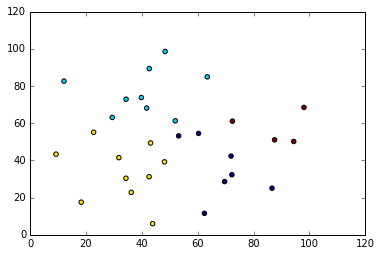

In [123]:
import numpy as np
from scipy import cluster
from matplotlib import pyplot

np.random.seed(123)
tests = np.reshape( np.random.uniform(0,100,60), (30,2) )
# tests[1:4]
# array([[ 22.68514536,  55.13147691],
#       [ 71.94689698,  42.31064601],
#       [ 98.07641984,  68.48297386]])

# #plot variance for each value for 'k' between 1,10
# initial = [cluster.vq.kmeans(tests,i) for i in range(1,10)]
# pyplot.plot([var for (cent,var) in initial])
# pyplot.show()

cent, var = initial[3]
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(tests,cent)
pyplot.scatter(tests[:,0], tests[:,1], c=assignment)
pyplot.show()

In [8]:
# view samples of product reviews, organized by KMeans cluster results
# viz.view_cluster_samples(10)
# viz.view_cluster_samples(5)
viz.view_cluster_samples(60)
# viz.view_cluster_samples(40)
# viz.view_cluster_samples(20)

--------------------------------------------------
cluster:  1
cluster size:  (1387, 4)
         ProductId  cluster  \
116930  B000WFPJIG        1   
117400  B000WFU8O6        1   
117516  B000WFUL3E        1   
1989    B00008CQVA        1   
117572  B000WFUL3E        1   
116384  B000WFN0VO        1   
117104  B000WFRQQ4        1   
115837  B000WFEN74        1   
115794  B000WFEN74        1   
116870  B000WFPJIG        1   
115814  B000WFEN74        1   
116392  B000WFN0VO        1   
117459  B000WFU8O6        1   
116140  B000WFKI82        1   
116492  B000WFN0VO        1   
1721    B000084EZ4        1   
117555  B000WFUL3E        1   
117608  B000WFUL3E        1   
117007  B000WFRQQ4        1   
116468  B000WFN0VO        1   
1970    B00008CQVA        1   
117108  B000WFRQQ4        1   
1709    B000084EZ4        1   
1997    B00008CQVA        1   
116108  B000WFKI82        1   
117058  B000WFRQQ4        1   
116231  B000WFKWDI        1   
1750    B000084EZ4        1   
116449  B000W